In [19]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [21]:
from PIL import Image
image_path = "./Training/anger/0.jpg"
img = Image.open(image_path)
print("Image size (width, height):", img.size)
print("Image mode:", img.mode)  # L代表的是灰度图

Image size (width, height): (48, 48)
Image mode: L


In [23]:
# 定义输入尺寸和超参数
IMG_SIZE = 48
BATCH_SIZE = 64
NUM_CLASSES = 7

# 数据文件夹路径
train_dir = "./Training"
validation_dir = "./PublicTest"

In [25]:
# 定义数据增强和预处理
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                # 调整为 224x224 像素 （因为后面使用ResNet）
    transforms.Grayscale(num_output_channels=3),  # 转换为 3 通道 （因为ResNet要求是彩色，而原图片是灰度）
    transforms.RandomHorizontalFlip(p=0.5),           # 随机水平翻转
    #transforms.RandomRotation(10),              # 随机旋转
    #transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ToTensor(),                      # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 使用预训练好的 ResNet 模型时，均值和标准差通常是根据预训练所使用的数据集（例如 ImageNet）预先计算好的。
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 创建数据集
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = ImageFolder(root=validation_dir, transform=validation_transforms)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 检查数据集是否正确加载
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

Number of training samples: 25337
Number of validation samples: 3589


In [27]:
#是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('training on CPU.......')
else:
    print('training on GPU.......')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training on GPU.......


In [29]:
# 当 feature_extracting=True 时，遍历 model.parameters()，将所有参数的 requires_grad 设置为 False。但是后面更新了fc层，所以只有全连接层是没有冻住的
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [31]:
model_ft = models.resnet50()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
def initialize_model(model_name, numclasses, feature_extract, use_pretrained = True):
    model_ft = None
    input_size = 0
    if model_name == "resnet50":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)   #选择一些层冻住
        num_ftrs = model_ft.fc.in_features   #得到最后一层的输入
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, numclasses),nn.LogSoftmax(dim=1))  #把最后一层的输出改为本数据库的分类数
        input_size = 224
    else:
        print("Invalid model name")
        exit()
        
    return model_ft, input_size

In [35]:
# 哪些层需要训练
model_name = 'resnet50'
feature_extract = True

model_ft, input_size = initialize_model(model_name, NUM_CLASSES, feature_extract, use_pretrained = True)

model_ft = model_ft.to(device)

#模型保存
filename = 'checkpoint.pth'

#是否训练所有层
params_toupdate = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t',name)
else:
    for name,param in model_ft.name_parameters():
        if param.requires_grad == True:
            print("\t", name)

D:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [37]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
optimizer = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # 学习率每7个epoch衰减为原来的1/10
criterion = nn.NLLLoss()  # 最后一层已经LogSoftMax()了，所以不能用nn.CrossEntropyLoss()来计算
model = model_ft

# train model
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_labels = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 显示训练进度
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # 调整学习率
    scheduler.step()

    # 评估模型
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Finished Training')

# 保存模型
torch.save(model, 'ResNet18_only_fc_.pt')

Epoch 1/30: 100%|██████████| 396/396 [01:17<00:00,  5.13it/s]


Epoch 1, Train Loss: 1.9773, Train Accuracy: 34.16%
Epoch 1, Val Loss: 2.4536, Val Accuracy: 26.55%


Epoch 2/30: 100%|██████████| 396/396 [01:18<00:00,  5.05it/s]


Epoch 2, Train Loss: 1.7331, Train Accuracy: 38.84%
Epoch 2, Val Loss: 2.3024, Val Accuracy: 34.08%


Epoch 3/30: 100%|██████████| 396/396 [01:17<00:00,  5.09it/s]


Epoch 3, Train Loss: 1.7365, Train Accuracy: 39.00%
Epoch 3, Val Loss: 3.0895, Val Accuracy: 29.76%


Epoch 4/30: 100%|██████████| 396/396 [01:17<00:00,  5.11it/s]


Epoch 4, Train Loss: 1.7907, Train Accuracy: 39.27%
Epoch 4, Val Loss: 3.3277, Val Accuracy: 37.28%


Epoch 5/30: 100%|██████████| 396/396 [01:19<00:00,  4.96it/s]


Epoch 5, Train Loss: 1.6791, Train Accuracy: 40.74%
Epoch 5, Val Loss: 4.7730, Val Accuracy: 32.40%


Epoch 6/30: 100%|██████████| 396/396 [01:21<00:00,  4.88it/s]


Epoch 6, Train Loss: 1.6604, Train Accuracy: 41.60%
Epoch 6, Val Loss: 2.6050, Val Accuracy: 34.77%


Epoch 7/30: 100%|██████████| 396/396 [01:19<00:00,  4.98it/s]


Epoch 7, Train Loss: 1.7008, Train Accuracy: 41.24%
Epoch 7, Val Loss: 3.0920, Val Accuracy: 37.42%


Epoch 8/30: 100%|██████████| 396/396 [01:19<00:00,  4.99it/s]


Epoch 8, Train Loss: 1.3070, Train Accuracy: 49.37%
Epoch 8, Val Loss: 1.8735, Val Accuracy: 41.71%


Epoch 9/30: 100%|██████████| 396/396 [01:19<00:00,  4.98it/s]


Epoch 9, Train Loss: 1.2730, Train Accuracy: 50.14%
Epoch 9, Val Loss: 1.9250, Val Accuracy: 41.68%


Epoch 10/30: 100%|██████████| 396/396 [01:19<00:00,  5.00it/s]


Epoch 10, Train Loss: 1.2754, Train Accuracy: 50.29%
Epoch 10, Val Loss: 1.7453, Val Accuracy: 42.02%


Epoch 11/30: 100%|██████████| 396/396 [01:19<00:00,  4.97it/s]


Epoch 11, Train Loss: 1.2708, Train Accuracy: 50.57%
Epoch 11, Val Loss: 2.0058, Val Accuracy: 40.76%


Epoch 12/30: 100%|██████████| 396/396 [01:19<00:00,  4.96it/s]


Epoch 12, Train Loss: 1.2690, Train Accuracy: 50.36%
Epoch 12, Val Loss: 1.9956, Val Accuracy: 40.51%


Epoch 13/30: 100%|██████████| 396/396 [01:16<00:00,  5.18it/s]


Epoch 13, Train Loss: 1.2702, Train Accuracy: 50.52%
Epoch 13, Val Loss: 1.9441, Val Accuracy: 40.82%


Epoch 14/30: 100%|██████████| 396/396 [01:16<00:00,  5.19it/s]


Epoch 14, Train Loss: 1.2766, Train Accuracy: 49.92%
Epoch 14, Val Loss: 2.0772, Val Accuracy: 40.37%


Epoch 15/30: 100%|██████████| 396/396 [01:16<00:00,  5.19it/s]


Epoch 15, Train Loss: 1.2223, Train Accuracy: 52.76%
Epoch 15, Val Loss: 1.8299, Val Accuracy: 41.71%


Epoch 16/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 16, Train Loss: 1.2275, Train Accuracy: 51.93%
Epoch 16, Val Loss: 1.7480, Val Accuracy: 42.71%


Epoch 17/30: 100%|██████████| 396/396 [01:16<00:00,  5.18it/s]


Epoch 17, Train Loss: 1.2229, Train Accuracy: 52.90%
Epoch 17, Val Loss: 1.7820, Val Accuracy: 42.83%


Epoch 18/30: 100%|██████████| 396/396 [01:16<00:00,  5.19it/s]


Epoch 18, Train Loss: 1.2259, Train Accuracy: 52.48%
Epoch 18, Val Loss: 1.7774, Val Accuracy: 43.24%


Epoch 19/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 19, Train Loss: 1.2232, Train Accuracy: 52.77%
Epoch 19, Val Loss: 1.8013, Val Accuracy: 42.52%


Epoch 20/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 20, Train Loss: 1.2233, Train Accuracy: 52.51%
Epoch 20, Val Loss: 1.8053, Val Accuracy: 41.60%


Epoch 21/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 21, Train Loss: 1.2183, Train Accuracy: 52.71%
Epoch 21, Val Loss: 1.8074, Val Accuracy: 43.30%


Epoch 22/30: 100%|██████████| 396/396 [01:16<00:00,  5.19it/s]


Epoch 22, Train Loss: 1.2110, Train Accuracy: 53.07%
Epoch 22, Val Loss: 1.7568, Val Accuracy: 43.35%


Epoch 23/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 23, Train Loss: 1.2208, Train Accuracy: 52.75%
Epoch 23, Val Loss: 1.7499, Val Accuracy: 42.91%


Epoch 24/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 24, Train Loss: 1.2094, Train Accuracy: 53.45%
Epoch 24, Val Loss: 1.7653, Val Accuracy: 43.13%


Epoch 25/30: 100%|██████████| 396/396 [01:16<00:00,  5.21it/s]


Epoch 25, Train Loss: 1.2143, Train Accuracy: 52.86%
Epoch 25, Val Loss: 1.7611, Val Accuracy: 43.13%


Epoch 26/30: 100%|██████████| 396/396 [01:16<00:00,  5.20it/s]


Epoch 26, Train Loss: 1.2150, Train Accuracy: 53.17%
Epoch 26, Val Loss: 1.7778, Val Accuracy: 42.96%


Epoch 27/30: 100%|██████████| 396/396 [01:16<00:00,  5.19it/s]


Epoch 27, Train Loss: 1.2115, Train Accuracy: 53.31%
Epoch 27, Val Loss: 1.7672, Val Accuracy: 43.02%


Epoch 28/30: 100%|██████████| 396/396 [01:16<00:00,  5.17it/s]


Epoch 28, Train Loss: 1.2132, Train Accuracy: 52.80%
Epoch 28, Val Loss: 1.7753, Val Accuracy: 43.13%


Epoch 29/30: 100%|██████████| 396/396 [01:16<00:00,  5.16it/s]


Epoch 29, Train Loss: 1.2168, Train Accuracy: 53.12%
Epoch 29, Val Loss: 1.7658, Val Accuracy: 42.99%


Epoch 30/30: 100%|██████████| 396/396 [01:16<00:00,  5.17it/s]


Epoch 30, Train Loss: 1.2122, Train Accuracy: 52.96%
Epoch 30, Val Loss: 1.7733, Val Accuracy: 42.60%
Finished Training


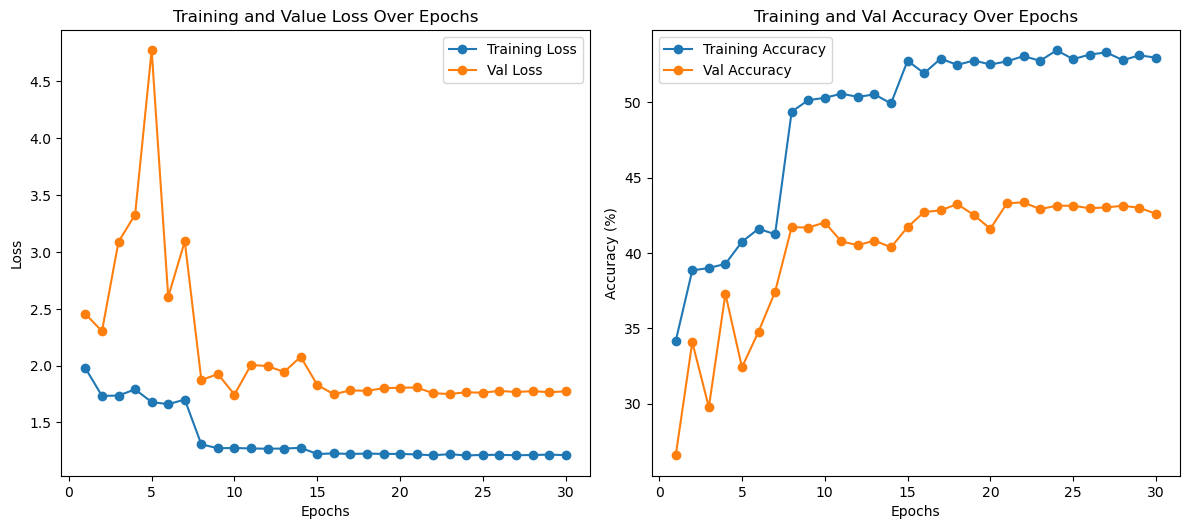

Precision: 0.4466
Recall: 0.4018
F1 Score (Weighted): 0.3770


In [41]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Draw the accuracy and loss curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 10))

# Plotting training and val loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Value Loss Over Epochs')
plt.legend()

# Plot training and val accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Val Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Calculating F1-score, Precision and Recall
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

# 测试

In [43]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 确保你的设备是 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64

test_dir = "./PrivateTest"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Using device: cuda
Number of test samples: 3589


C:\Users\HE\AppData\Local\Temp\ipykernel_21408\999879087.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("ResNet18_only_fc_.pt")


Test Accuracy: 43.22%
Confusion Matrix:
 [[183   4  54  87  81  81   1]
 [ 18  11   2  13   7   4   0]
 [ 87   4 165  91  85  93   3]
 [ 54   4  47 639  85  49   1]
 [ 60   2  60 109 310  83   2]
 [ 73   2  66 114 117 222   0]
 [ 39   0 191  74  73  18  21]]


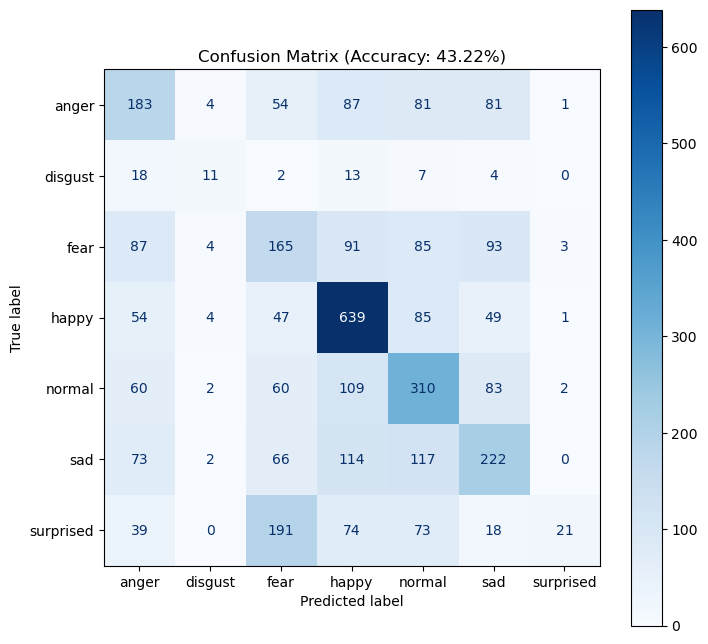

In [45]:
# 定义模型结构（与保存权重时一致）
model = torch.load("ResNet18_only_fc_.pt")
model = model.to(device)
model.eval()  # 切换到评估模式

# 初始化真实标签和预测标签
all_labels = []
all_preds = []

# 模型测试并记录标签
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# 绘制混淆矩阵
labels = test_dataset.classes  # 获取类别名称
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f}%)")
plt.show()